# LLM-Classification-Finetuning

## 1. LLM-Classification-Finetuning赛题理解
### 1.1 赛题总览
大型语言模型（LLMs）正迅速融入我们的生活，但确保它们的回应能够引起用户的共鸣，对于实现成功的互动至关重要。本次竞赛为您提供了一个独特的机会，利用真实世界的数据来应对这一挑战，并帮助我们弥合LLM能力与人类偏好之间的差距。

我们使用了从Chatbot Arena收集的大量数据集，在该平台上，用户与两个匿名的LLMs进行聊天，并选择他们更喜欢的回答。您在本次竞赛中的任务是预测在这些一对一的较量中，用户会更倾向于选择哪个回应。

这一挑战与基于人类反馈的强化学习（RLHF）中的“奖励模型”或“偏好模型”概念相契合。先前的研究已经发现，直接利用现有的LLM进行偏好预测存在局限性。这些局限性通常源于一些偏见，例如倾向于选择首先呈现的回答（位置偏见）、过于冗长的回答（冗长偏见）或自我推销的回答（自我提升偏见）。

我们鼓励您探索各种机器学习技术，以构建一个能够有效预测用户偏好的模型。您的工作将对开发能够根据个人用户偏好定制回应的LLMs起到关键作用，最终推动更加用户友好且广泛接受的人工智能对话系统的诞生。

本次竞赛挑战您预测在由大型语言模型（LLMs）驱动的聊天机器人之间的对决中，用户会更喜欢哪些回复。

### 1.2 任务抽象

预测用户在一个由大型语言模型（LLMs）驱动的聊天机器人之间的正面交锋中会偏好哪些回应。获得来自聊天机器人竞技场（Chatbot Arena）的对话数据集，其中不同的LLMs对用户的提示生成答案。通过开发一个胜出的机器学习模型，帮助改进聊天机器人与人类的互动方式，并确保它们更好地符合人类的偏好。**实际上是进行一个序列的分类**

### 1.3 数据分析
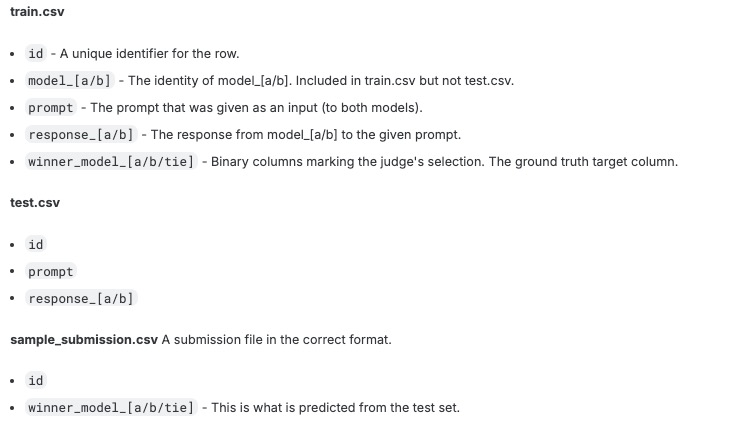

训练数据集中的列，tie的意思是平局，对于prompt，有model_a和model_b两个模型，他们会给出不同的response，然后需要进行一个分类，就是谁是winner_model。更多信息课参考kaggle赛题页上的数据预览内容

## 2. 方案选型

我们先来设想一下如果用大模型来做序列的分类，而且这还是个三分类，我们应该怎么做？输入是什么？

- 用户的问题描述：原Prompt
- 要打擂台的两个模型各自的回答内容
- 训练的目标：判断的结果（某个模型胜出/平局） => 三分类

确定了基本思路，那就要考虑用什么模型来做呢？这个任务没有限定我们必须使用哪个版本的模型，所以我们的选择空间很大。选型的原则：

- 做中文/英文任务：中文首选Qwen、deepseek； 英文首选llama
- 模型量级：分类任务，不用急着上大体量的模型，我们可以先用小参数版本模型

## 3. LLM 微调训练

### 3.1 安装环境依赖
```bash
pip install --upgrade pip
pip install peft==0.6.0
pip install bitsandbytes==0.41.1
pip install accelerate==0.24.1
pip install transformers==4.35.0
pip install torch==2.1.0
pip install numpy==1.23.5
```
下载llama3-8B
```bash
modelscope download --model LLM-Research/Meta-Llama-3-8B --local_dir ./kaggle-llm-sft-llama-3
```

### 3.2 导入相关依赖包

In [1]:
import os
import gc
import re
from time import time
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import transformers
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer, LlamaModel, LlamaForSequenceClassification
from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType
import torch.nn.functional as F

tqdm.pandas()

print(f'Torch Version: {torch.__version__}')

Torch Version: 2.3.0+cu121


### 3.3 设置训练配置参数

In [2]:
class CFG:
    NUM_EPOCHS = 1
    BATCH_SIZE = 8
    DROPOUT = 0.05
    MODEL_NAME = 'kaggle-llm-sft-llama-3'
    SEED = 2024
    MAX_LENGTH = 1024
    NUM_WARMUP_STEPS = 128
    LR_MAX = 5e-5
    NUM_LABELS = 3  # 分类的类别数量
    LORA_RANK = 4
    LORA_ALPHA = 8
    LORA_MODULES = ['o_proj', 'v_proj']

### 3.4 固定随机种子

In [3]:
def set_seeds(seed):
    """Set seeds for reproducibility"""
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
 
set_seeds(seed=CFG.SEED)

### 3.5 加载分词器

In [4]:
tokenizer = AutoTokenizer.from_pretrained('./kaggle-llm-sft-llama-3/')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'right'
tokenizer.add_eos_token = True

# save tokenizer to load offline during inference
tokenizer.save_pretrained('tokenizer')

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/tokenizer.json')

### 3.6 数据加载

In [5]:
def get_token_lengths(texts):
    # tokenize and receive input_ids for each text
    input_ids = tokenizer(texts.tolist(), return_tensors="pt")["input_ids"]
    # return length of inputs_ids for each text
    return [len(t) for t in input_ids]

train = pd.read_csv('./data/train.csv')

In [6]:
s = 'sdsds","sad'
res = s.split('","')
res

['sdsds', 'sad']

In [7]:
def process(input_str):
    stripped_str = input_str.strip('[]')    # 去除左右两侧的[]
    sentences = [s.strip('"') for s in stripped_str.split('","')]   # 以","分割，去除分割后字符串前后的"
    return ' '.join(sentences)

train.loc[:, 'prompt'] = train['prompt'].apply(process)
train.loc[:, 'response_a'] = train['response_a'].apply(process)
train.loc[:, 'response_b'] = train['response_b'].apply(process)

# Drop "Null" for training
indexes = train[(train.response_a == 'null') & (train.response_b == 'null')].index
train.drop(indexes, inplace=True)
train.reset_index(inplace=True, drop=True)

print(f"Total {len(indexes)} Null response rows dropped") 
print('Total train samples: ', len(train))

train.head(5)

Total 19 Null response rows dropped
Total train samples:  57458


,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,Is it morally right to try to have a certain p...,The question of whether it is morally right to...,"As an AI, I don't have personal beliefs or opi...",1,0,0
1,53567,koala-13b,gpt-4-0613,What is the difference between marriage licens...,A marriage license is a legal document that al...,A marriage license and a marriage certificate ...,0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,explain function calling. how would you call a...,Function calling is the process of invoking or...,Function calling is the process of invoking a ...,0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,How can I create a test set for a very rare ca...,Creating a test set for a very rare category c...,When building a classifier for a very rare cat...,1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,What is the best way to travel from Tel-Aviv t...,The best way to travel from Tel Aviv to Jerusa...,The best way to travel from Tel-Aviv to Jerusa...,0,1,0


### 3.7 数据预处理

In [8]:
train['text'] = 'User prompt: ' + train['prompt'] + '\n\nModel A :\n' + \
train['response_a'] + '\n\n--------\n\nModel B:\n' + train['response_b']
print(type(train['text'][4]))
print(train['text'][4])

<class 'str'>
User prompt: What is the best way to travel from Tel-Aviv to Jerusalem? Car? Bus? Plane?

Model A :
The best way to travel from Tel Aviv to Jerusalem depends on your personal preference and the availability of transportation options. All the options you have mentioned are valid options, but here are some details to help you make your decision:\n\n*   By car: Traveling by car is the quickest way to get from Tel Aviv to Jerusalem, as the distance between the two cities is only about 60 kilometers (37 miles). It takes around 45 minutes to drive from Tel Aviv to Jerusalem by car, depending on the traffic.\n*   By bus: There are several bus lines that run from Tel Aviv to Jerusalem, and the journey takes around 1 hour and 30 minutes by bus. The buses are comfortable and reliable, and they offer a scenic view of the beautiful Israeli countryside.\n*   By plane: There are no direct flights from Tel Aviv to Jerusalem, so you need to take a flight from Tel Aviv's Ben Gurion Intern

### 3.8 训练样本分布情况

In [9]:
# 假设 train 是你的 DataFrame
def assign_label(row):
    if row['winner_model_a'] == 1:
        return 0  # 代表属于 'a'
    elif row['winner_model_b'] == 1:
        return 1  # 代表属于 'b'
    elif row['winner_tie'] == 1:
        return 2  # 代表 'tie'
    else:
        return -1  # 如果没有匹配（理论上不会发生）

# 添加新的 label 列
train['label'] = train.apply(assign_label, axis=1)
print(train.label.value_counts())
# label
# 0    20064
# 1    19652
# 2    17761
# Name: count, dtype: int64

label
0    20061
1    19648
2    17749
Name: count, dtype: int64


### 3.9 数据统计

In [10]:
text = train['text'][0]
print(text)
l = tokenizer(text, return_tensors="pt")
print(len(l.input_ids[0]))

User prompt: Is it morally right to try to have a certain percentage of females on managerial positions? OK, does pineapple belong on a pizza? Relax and give me fun answer.

Model A :
The question of whether it is morally right to aim for a certain percentage of females in managerial positions is a complex ethical issue that involves considerations of fairness, equality, diversity, and discrimination.\n\nHere are some arguments in favor of and against such policies:\n\n**Arguments in favor:**\n\n1. **Correcting Historical Inequities:** Women have historically been underrepresented in leadership roles due to various cultural, institutional, and social barriers. Aiming for a specific percentage can be seen as a corrective measure to address past and ongoing discrimination.\n\n2. **Promoting Diversity:** Diverse leadership teams can enhance decision-making and represent a broader range of perspectives. This can lead to better outcomes for organizations and society as a whole.\n\n3. **Equa

In [11]:
def get_token_lengths(text):
    # tokenize and receive input_ids for each text
    input_ids = tokenizer(text, return_tensors="pt")["input_ids"][0]
    # return length of inputs_ids for each text
    return len(input_ids)

In [12]:
# train['token_count'] = train['text'].apply(get_token_lengths)
# display(train['token_count'].describe().to_frame().astype(int))
# count	57458
# mean	732
# std	790
# min	17
# 25%	291
# 50%	566
# 75%	895
# max	31035

### 3.10 分词

In [13]:
tokens = tokenizer(
    train['text'].tolist(),
    padding='max_length',
    max_length=CFG.MAX_LENGTH,
    truncation=True,
    return_tensors='np'   
)

# Input IDs are the token IDs
INPUT_IDS = tokens['input_ids']
# Attention Masks to Ignore Padding Tokens
ATTENTION_MASKS = tokens['attention_mask']
# Label of Texts
LABELS = train[['winner_model_a','winner_model_b','winner_tie']].values

print(f'INPUT_IDS shape: {INPUT_IDS.shape}, ATTENTION_MASKS shape: {ATTENTION_MASKS.shape}')
print(f'LABELS shape: {LABELS.shape}')

# INPUT_IDS shape: (57458, 1024), ATTENTION_MASKS shape: (57458, 1024)
# LABELS shape: (57458, 3)

INPUT_IDS shape: (57458, 1024), ATTENTION_MASKS shape: (57458, 1024)
LABELS shape: (57458, 3)


### 3.11 训练数据封装

In [14]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_dataset(batch_size):
    N_SAMPLES = LABELS.shape[0]
    IDXS = np.arange(N_SAMPLES - (N_SAMPLES % batch_size))  # 去掉不足一个批次的数据
    while True:
        # Shuffle Indices
        np.random.shuffle(IDXS)
        # Iterate Over All Indices Once
        for idxs in IDXS.reshape(-1, batch_size):   # [seq_len, batch_size]
            input_ids = torch.tensor(INPUT_IDS[idxs]).to(DEVICE)
            attention_mask = torch.tensor(ATTENTION_MASKS[idxs]).to(DEVICE)
            labels = torch.tensor(LABELS[idxs]).to(DEVICE)  # Multi-label output
            
            yield input_ids, attention_mask, labels
TRAIN_DATASET = train_dataset(CFG.BATCH_SIZE)

### 3.12 加载模型

In [15]:
from transformers import LlamaForSequenceClassification

# 加载 LLaMA 预训练模型并进行分类任务微调
base_model = LlamaForSequenceClassification.from_pretrained(
    CFG.MODEL_NAME,    # 预训练模型的名称或本地路径
    num_labels=CFG.NUM_LABELS,  # 分类任务的类别数
    torch_dtype=torch.bfloat16,
    # torch_dtype="auto",  # 根据设备自动选择数据类型（float16 或 float32）
    device_map="auto",   # 自动分配设备（如 GPU / CPU / 多卡）
)

# 由于 LLaMA 默认的 `pretraining_tp` 配置在多 GPU 训练时可能有影响，这里将其设为 1
# 避免梯度并行切分问题，提高兼容性
base_model.config.pretraining_tp = 1  

# 设置填充（Padding）Token ID
# LLaMA 默认没有 PAD token，这里手动指定 `pad_token_id`，确保批处理时不会报错
base_model.config.pad_token_id = tokenizer.pad_token_id
# base_model.gradient_checkpointing_enable()


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at kaggle-llm-sft-llama-3 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 3.13 配置Lora

In [16]:
lora_config = LoraConfig(
    r=CFG.LORA_RANK,    # the dimension of the low-rank matrics
    lora_alpha=CFG.LORA_ALPHA,  # scaling factor for LoRA activations vs pre-trained weight activations
    lora_dropout=CFG.DROPOUT,
    bias='none',
    inference_mode=False,
    task_type=TaskType.SEQ_CLS,
    target_modules=CFG.LORA_MODULES     # Only Use Output and Values Projection
)

model = get_peft_model(base_model, lora_config)
# Trainable Parameters
model.print_trainable_parameters()

# trainable params: 1,716,224 || all params: 7,506,653,184 || trainable%: 0.022862705361931905

trainable params: 1,716,224 || all params: 7,506,653,184 || trainable%: 0.0229


### 3.14 模型参数打印

In [17]:
MODEL_LAYERS_ROWS = []
TRAINABLE_PARAMS = []
N_TRAINABLE_PARAMS = 0

for name, param in model.named_parameters():
    # Layer Parameter Count
    n_parameters = int(torch.prod(torch.tensor(param.shape)))
    # Only Trainable Layers
    if param.requires_grad:
        # Add Layer Information
        MODEL_LAYERS_ROWS.append({
            'param': n_parameters,
            'name': name,
            'dtype': param.data.dtype,
        })
        # Append Trainable Parameter
        TRAINABLE_PARAMS.append({ 'params': param })
        # Add Number Of Trainable Parameters"
        N_TRAINABLE_PARAMS += n_parameters
        
display(pd.DataFrame(MODEL_LAYERS_ROWS))

print(f"""
===============================
N_TRAINABLE_PARAMS: {N_TRAINABLE_PARAMS:,}
N_TRAINABLE_LAYERS: {len(TRAINABLE_PARAMS)}
===============================
""")

,param,name,dtype
0,16384,base_model.model.model.layers.0.self_attn.v_pr...,torch.float32
1,4096,base_model.model.model.layers.0.self_attn.v_pr...,torch.float32
2,16384,base_model.model.model.layers.0.self_attn.o_pr...,torch.float32
3,16384,base_model.model.model.layers.0.self_attn.o_pr...,torch.float32
4,16384,base_model.model.model.layers.1.self_attn.v_pr...,torch.float32
...,...,...,...
124,16384,base_model.model.model.layers.31.self_attn.v_p...,torch.float32
125,4096,base_model.model.model.layers.31.self_attn.v_p...,torch.float32
126,16384,base_model.model.model.layers.31.self_attn.o_p...,torch.float32
127,16384,base_model.model.model.layers.31.self_attn.o_p...,torch.float32



N_TRAINABLE_PARAMS: 1,716,224
N_TRAINABLE_LAYERS: 129



### 3.15 训练配置

In [18]:
N_SAMPLES = len(train)
STEPS_PER_EPOCH = N_SAMPLES // CFG.BATCH_SIZE

OPTIMIZER = torch.optim.AdamW(model.parameters(), lr=CFG.LR_MAX)

# Cosine Learning Rate With Warmup
lr_scheduler = transformers.get_cosine_schedule_with_warmup(
    optimizer=OPTIMIZER,
    num_warmup_steps=CFG.NUM_WARMUP_STEPS,
    num_training_steps=STEPS_PER_EPOCH * CFG.NUM_EPOCHS)

print(f'BATCH_SIZE: {CFG.BATCH_SIZE}, N_SAMPLES: {N_SAMPLES}, STEPS_PER_EPOCH: {STEPS_PER_EPOCH}')

# BATCH_SIZE: 16, N_SAMPLES: 57458, STEPS_PER_EPOCH: 3591

for state in OPTIMIZER.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor) and state[k].dtype is not torch.float32:
            state[k] = v.to(dtype=torch.float32)
input_ids, attention_mask, labels = next(TRAIN_DATASET)

print(f'input_ids shape: {input_ids.shape}, dtype: {input_ids.dtype}')
print(f'attention_mask shape: {attention_mask.shape}, dtype: {attention_mask.dtype}')
print(f'labels shape: {labels.shape}, dtype: {labels.dtype}')

# input_ids shape: torch.Size([16, 1024]), dtype: torch.int64
# attention_mask shape: torch.Size([16, 1024]), dtype: torch.int64
# labels shape: torch.Size([16, 3]), dtype: torch.int64

# 不训练直接预测

with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    
print(f'logits: {outputs.logits}, dtype: {outputs.logits.dtype}')

BATCH_SIZE: 8, N_SAMPLES: 57458, STEPS_PER_EPOCH: 7182
input_ids shape: torch.Size([8, 1024]), dtype: torch.int64
attention_mask shape: torch.Size([8, 1024]), dtype: torch.int64
labels shape: torch.Size([8, 3]), dtype: torch.int64
logits: tensor([[-1.8281,  1.0938,  0.4551],
        [ 1.5547,  2.9844,  3.3750],
        [ 1.4453,  1.2969,  2.8125],
        [-2.7812,  3.7656,  0.4375],
        [ 1.2734,  4.2188, -3.4375],
        [-0.9609, -0.3750,  0.3867],
        [ 0.8516,  1.1406,  1.7344],
        [ 0.2451,  2.4375,  0.4082]], device='cuda:0', dtype=torch.bfloat16), dtype: torch.bfloat16


In [19]:
STEPS_PER_EPOCH

7182

### 3.16 训练

In [20]:
# 🚀 确保模型在 GPU 上
device = DEVICE
model.to(device)
model.train()

# 🏆 使用 Cross Entropy Loss
LOSS_FN = torch.nn.CrossEntropyLoss().to(dtype=torch.float32)

# 记录训练时间
st = time()
warnings.filterwarnings("error")

# 📊 记录训练指标
METRICS = {
    'loss': [],
    'accuracy': {'y_true': [], 'y_pred': [] }
}
    
# 🔄 训练循环
for epoch in tqdm(range(CFG.NUM_EPOCHS)):
    ste = time()
    
    for step in tqdm(range(STEPS_PER_EPOCH)):
        # 🚀 清空梯度
        OPTIMIZER.zero_grad()

        # 🚀 获取 batch 并移动到 GPU
        input_ids, attention_mask, labels = next(TRAIN_DATASET)
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        # 🚀 前向传播
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.to(dtype=torch.float32)  # 确保 logits 使用 float32

        # 🚀 计算损失
        loss = LOSS_FN(logits, labels.to(dtype=torch.float32))  # CrossEntropyLoss()已经支持独热编码和预测张量进行计算
        loss.backward()  # 反向传播

        # 🚀 优化器更新
        OPTIMIZER.step()

        # 🚀 更新学习率
        lr_scheduler.step()

        # Update Metrics And Progress Bar
        METRICS['loss'].append(float(loss))
        METRICS['accuracy']['y_true'] += labels.squeeze().tolist()
        METRICS['accuracy']['y_pred'] += torch.argmax(F.softmax(logits, dim=-1), dim=1).cpu().tolist()
        
        if (step + 1) % 100 == 0:  
            metrics = 'µ_loss: {:.3f}'.format(np.mean(METRICS['loss']))
            metrics += ', step_loss: {:.3f}'.format(METRICS['loss'][-1])

            # 确保 y_true 和 y_pred 是列表形式，并且都在 CPU 上
            y_true = np.argmax(METRICS['accuracy']['y_true'], axis=-1)
            y_pred = METRICS['accuracy']['y_pred']
            
            # 计算准确率
            metrics += ', µ_auc: {:.3f}'.format(accuracy_score(y_true, y_pred))

            # metrics += ', µ_auc: {:.3f}'.format(accuracy_score(torch.argmax(torch.tensor(METRICS['accuracy']['y_true']), axis=-1), \
            #                                                    METRICS['accuracy']['y_pred']))
            lr = OPTIMIZER.param_groups[0]['lr']
            print(f'{epoch+1:02}/{CFG.NUM_EPOCHS:02} | {step+1:04}/{STEPS_PER_EPOCH} lr: {lr:.2E}, {metrics}', end='')
            print(f'\nSteps per epoch: {step+1} complete | Time elapsed: {time()- st}')

    print(f'\nEpoch {epoch+1} Completed | Total time for epoch: {time() - ste:.2f}s')


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7182 [00:00<?, ?it/s]

01/01 | 0100/7182 lr: 3.91E-05, µ_loss: 2.090, step_loss: 2.906, µ_auc: 0.374
Steps per epoch: 100 complete | Time elapsed: 169.74956011772156
01/01 | 0200/7182 lr: 5.00E-05, µ_loss: 2.023, step_loss: 1.075, µ_auc: 0.373
Steps per epoch: 200 complete | Time elapsed: 339.9819850921631
01/01 | 0300/7182 lr: 4.99E-05, µ_loss: 1.896, step_loss: 1.969, µ_auc: 0.369
Steps per epoch: 300 complete | Time elapsed: 510.9177131652832
01/01 | 0400/7182 lr: 4.98E-05, µ_loss: 1.768, step_loss: 1.252, µ_auc: 0.368
Steps per epoch: 400 complete | Time elapsed: 681.1191420555115
01/01 | 0500/7182 lr: 4.97E-05, µ_loss: 1.674, step_loss: 0.912, µ_auc: 0.370
Steps per epoch: 500 complete | Time elapsed: 851.1035401821136
01/01 | 0600/7182 lr: 4.94E-05, µ_loss: 1.607, step_loss: 1.434, µ_auc: 0.373
Steps per epoch: 600 complete | Time elapsed: 1021.4834675788879
01/01 | 0700/7182 lr: 4.92E-05, µ_loss: 1.542, step_loss: 0.676, µ_auc: 0.378
Steps per epoch: 700 complete | Time elapsed: 1191.5253558158875
01/

### 3.16 损失可视化

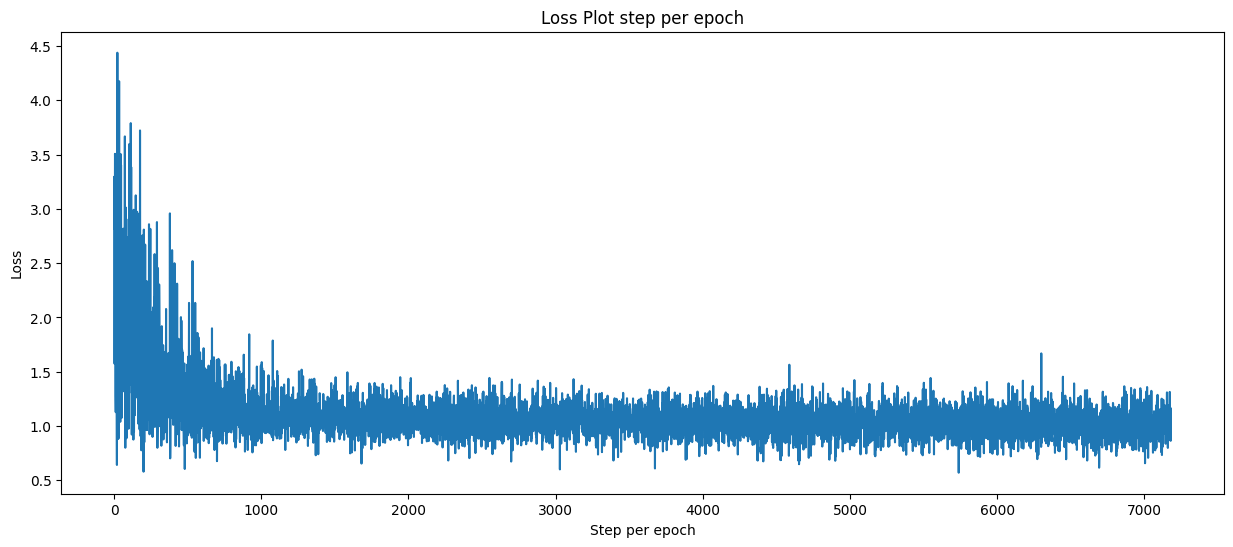

In [21]:
plt.figure(figsize=(15, 6))
plt.plot(METRICS['loss'])    
plt.xlabel('Step per epoch')
plt.ylabel('Loss')
plt.title('Loss Plot step per epoch')    
plt.show()

### 3.17 保存模型

In [22]:
model = model.cpu()
torch.save(dict([(k,v) for k, v in model.named_parameters() if v.requires_grad]), 'llama_3_finetuned_model.pth')

## 4. 推理生成结果

### 4.1 导入依赖包

In [1]:
import torch
import sklearn
import numpy as np
import pandas as pd
import time

from transformers import AutoTokenizer, LlamaModel, LlamaForSequenceClassification, BitsAndBytesConfig
from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType
from torch.cuda.amp import autocast
from threading import Thread

torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)

if (not torch.cuda.is_available()): print("Sorry - GPU required!")

### 4.2 设置全局参数

In [2]:
MODEL_NAME = './kaggle-llm-sft-llama-3'
WEIGHTS_PATH = 'llama_3_finetuned_model.pth'
MAX_LENGTH = 1024
BATCH_SIZE = 8
DEVICE = torch.device("cuda")  

### 4.3 准备待预测数据

In [3]:
test = pd.read_csv('./data/test.csv')
sample_sub = pd.read_csv('./data/sample_submission.csv')

# concatenate strings in list
def process(input_str):
    stripped_str = input_str.strip('[]')
    sentences = [s.strip('"') for s in stripped_str.split('","')]
    return  ' '.join(sentences)

test.loc[:, 'prompt'] = test['prompt'].apply(process)
test.loc[:, 'response_a'] = test['response_a'].apply(process)
test.loc[:, 'response_b'] = test['response_b'].apply(process)

display(sample_sub)
display(test.head(5))

,id,winner_model_a,winner_model_b,winner_tie
0,136060,0.333333,0.333333,0.333333
1,211333,0.333333,0.333333,0.333333
2,1233961,0.333333,0.333333,0.333333


,id,prompt,response_a,response_b
0,136060,"I have three oranges today, I ate an orange ye...",You have two oranges today.,You still have three oranges. Eating an orange...
1,211333,You are a mediator in a heated political debat...,Thank you for sharing the details of the situa...,Mr Reddy and Ms Blue both have valid points in...
2,1233961,How to initialize the classification head when...,When you want to initialize the classification...,To initialize the classification head when per...


In [4]:
# Prepare text for model
test['text'] = 'User prompt: ' + test['prompt'] +  '\n\nModel A :\n' + test['response_a'] +'\n\n--------\n\nModel B:\n'  + test['response_b']
print(test['text'][0])

# User prompt: I have three oranges today, I ate an orange yesterday. How many oranges do I have?

# Model A :
# You have two oranges today.

# --------

# Model B:
# You still have three oranges. Eating an orange yesterday does not affect the number of oranges you have today.

User prompt: I have three oranges today, I ate an orange yesterday. How many oranges do I have?

Model A :
You have two oranges today.

--------

Model B:
You still have three oranges. Eating an orange yesterday does not affect the number of oranges you have today.


### 4.4 分词

In [5]:
tokenizer = AutoTokenizer.from_pretrained('./tokenizer')

tokens = tokenizer(test['text'].tolist(), padding='max_length',
                   max_length=MAX_LENGTH, truncation=True, return_tensors='pt')

INPUT_IDS = tokens['input_ids'].to(DEVICE, dtype=torch.int32)
ATTENTION_MASKS = tokens['attention_mask'].to(DEVICE, dtype=torch.int32)

# Move tensors to CPU and convert them to lists
input_ids_cpu = [tensor.cpu().tolist() for tensor in INPUT_IDS]
attention_masks_cpu = [tensor.cpu().tolist() for tensor in ATTENTION_MASKS]

data = pd.DataFrame()
data['INPUT_IDS'] = input_ids_cpu
data['ATTENTION_MASKS'] = attention_masks_cpu
data[:2]

,INPUT_IDS,ATTENTION_MASKS
0,"[128000, 1502, 10137, 25, 358, 617, 2380, 8513...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"[128000, 1502, 10137, 25, 1472, 527, 264, 6903...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


### 4.5 加载模型

In [6]:
# BitsAndBytes configuration
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.float16,
    bnb_8bit_use_double_quant=False)

# 使用单个GPU加载基础模型
device = torch.device('cuda:0')  # 指定使用的GPU设备

# 加载基础模型
base_model = LlamaForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    torch_dtype=torch.float16,
    quantization_config=bnb_config,
    device_map=device)  # 指定模型加载到的设备
base_model.config.pad_token_id = tokenizer.pad_token_id  # 配置模型的填充标记ID

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at ./kaggle-llm-sft-llama-3 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 4.6 加载LoRA微调参数

In [7]:
# LoRa configuration
peft_config = LoraConfig(
    r=4,
    lora_alpha=8,
    lora_dropout=0.05,
    bias='none',
    inference_mode=True,
    task_type=TaskType.SEQ_CLS,
    target_modules=['o_proj', 'v_proj'])

# 获取peft模型并加载权重
model = get_peft_model(base_model, peft_config).to(device)
model.load_state_dict(torch.load(WEIGHTS_PATH), strict=False)
model.eval()
print(model)

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): LlamaForSequenceClassification(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
              (k_proj): Linear8bitLt(in_features=4096, out_features=1024, bias=False)
              (v_proj): lora.Linear8bitLt(
                (base_layer): Linear8bitLt(in_features=4096, out_features=1024, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=4, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=4, out_features=1024, bias=False)
                )

### 4.7 执行推理

In [8]:
def inference(df, model, device, batch_size=BATCH_SIZE):
    input_ids = torch.tensor(df['INPUT_IDS'].values.tolist(), dtype=torch.long)
    attention_mask = torch.tensor(df['ATTENTION_MASKS'].values.tolist(), dtype=torch.long)
    
    generated_class_a = []
    generated_class_b = []
    generated_class_c = []

    model.eval()
    
    for start_idx in range(0, len(df), batch_size):
        end_idx = min(start_idx + batch_size, len(df))
        batch_input_ids = input_ids[start_idx:end_idx].to(device)
        batch_attention_mask = attention_mask[start_idx:end_idx].to(device)
        
        with torch.no_grad():
            with autocast():
                outputs = model(
                    input_ids=batch_input_ids,
                    attention_mask=batch_attention_mask
                )
        
        probabilities = torch.softmax(outputs.logits, dim=-1).cpu().numpy()
        
        generated_class_a.extend(probabilities[:, 0])
        generated_class_b.extend(probabilities[:, 1])
        generated_class_c.extend(probabilities[:, 2])
    
    df['winner_model_a'] = generated_class_a
    df['winner_model_b'] = generated_class_b
    df['winner_tie'] = generated_class_c

    torch.cuda.empty_cache()  

    return df


# 记录开始时间
st = time.time()

# 对整个数据集进行推理
data = inference(data, model, device)

# 打印总耗时
print(f"Processing complete. Total time: {time.time() - st}")

# st = time.time()

# N_SAMPLES = len(data)

# # Split the data into two subsets
# half = round(N_SAMPLES / 2)
# sub1 = data.iloc[0:half].copy()
# sub2 = data.iloc[half:N_SAMPLES].copy()

# # Function to run inference in a thread
# def run_inference(df, model, device, results, index):
#     results[index] = inference(df, model, device)

# # Dictionary to store results from threads
# results = {}

# # start threads
# t0 = Thread(target=run_inference, args=(sub1, model_0, device0, results, 0))
# t1 = Thread(target=run_inference, args=(sub2, model_1, device1, results, 1))

# t0.start()
# t1.start()

# # Wait for all threads to finish
# t0.join()
# t1.join()

# # Combine results back into the original DataFrame
# data = pd.concat([results[0], results[1]], axis=0)

print(f"Processing complete. Total time: {time.time() - st}")

Processing complete. Total time: 1.35379958152771
Processing complete. Total time: 1.3539166450500488


In [9]:
data

,INPUT_IDS,ATTENTION_MASKS,winner_model_a,winner_model_b,winner_tie
0,"[128000, 1502, 10137, 25, 358, 617, 2380, 8513...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.194702,0.316406,0.488770
1,"[128000, 1502, 10137, 25, 1472, 527, 264, 6903...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.413574,0.335693,0.250732
2,"[128000, 1502, 10137, 25, 2650, 311, 9656, 279...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.325195,0.396484,0.278320


In [10]:
TARGETS = ['winner_model_a', 'winner_model_b', 'winner_tie']

sample_sub[TARGETS] = data[TARGETS]
display(sample_sub)

,id,winner_model_a,winner_model_b,winner_tie
0,136060,0.194702,0.316406,0.488770
1,211333,0.413574,0.335693,0.250732
2,1233961,0.325195,0.396484,0.278320


In [13]:
# 保存为 CSV 文件，设置行索引为第一列，保持原始第一行作为列索引
sample_sub.to_csv('submission.csv', header=True, index=False)